# Comparing mean feature values with the hospital thrombolysis rates.

**Research question: What is the relationship between the mean feature values and the hospital thrombolysis rate (per hospital)?**

## Plain English summary

We fit linear regressions and multiple regressions on mean SHAP values to hospital thrombolysis rates (in notebooks 03e and 03f). Here we do the same but instead of using SHAP values, we will use the feature values (mean of those attending each hospital).

For this analysis, the raw data does not have a Stroke Team value to include in the regressions as it is the field that we are grouping on to calculate the means. Whereas there is a SHAP value for the hospital attended which we included in the regressions.

## Data (no model)

No model. Using all the data (concat the 5 test sets). The 10 features are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)

And one target feature:
* Thrombolysis: Did the patient receive thrombolysis (0 = No, 1 = Yes)

## Aims

* Calculate mean feature values per hosptial attended
* Understand the relationship between each mean feature value and hosptial thrombolysis rate, and whether can fit a multiple regression from the mean feature values for hospital thrombolysis rate - look at using subsets of features.
* Use subsets of features: 1) patient descriptive features 2) hospital descriptive features.

## Observations
* SHAP contains more information about the data in relation to the hosptial IVT rate
* There is a SHAP value for hosptial attended, no data value equivalant for the raw dataset (stroke team is used only to group the data and calcluate the means of the other features).

## Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from xgboost import XGBClassifier

# Import shap for shapley values
import shap # `pip install shap` if neeed

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from sklearn import linear_model

import os
import pickle

import math # to .floor and .ceil

# So can take deep copy
import copy

from os.path import exists
import json

/home/kerry/miniconda3/envs/samuel2/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/kerry/miniconda3/envs/samuel2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set filenames

In [2]:
# Set up strings (describing the model) to use in filenames
number_of_features_to_use = 10
model_text = f'xgb_{number_of_features_to_use}_features'
notebook = '03h'

## Create output folders if needed

In [3]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)   

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/01_feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data

Data has previously been split into 5 stratified k-fold splits.

For this exercise, we will fit a model using all of the data (rather than train/test splits used to assess accuracy). We will join up all of the test data (by definition, each instance exists only once across all of the 5 test sets)

In [5]:
data_loc = '../data/kfold_5fold/'

In [6]:
# Initialise empty list
test_data_kfold = []

# Read in the names of the selected features for the model
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# For each k-fold split
for i in range(5):
    # Read in test set, restrict to chosen features, rename titles, & store
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test.rename(columns=dict_feature_name, inplace=True)
    test_data_kfold.append(test)

# Join all the test sets. Set "ignore_index = True" to reset the index in the
#   new dataframe (to run from 0 to n-1), otherwise get duplicate index values
data = pd.concat(test_data_kfold, ignore_index=True)

## Get list of feature names
And remove Thrombolysis (as not a value to get the mean for)

In [7]:
feature_names = list(test_data_kfold[0])
feature_names.remove('Thrombolysis')

### Define the features in each multiple regression

Have two multiple regressions: patient and hosptial

In [8]:
patient_features = ['Infarction','Stroke severity',
                    'Precise onset time','Prior disability level',
                    'Use of AF anticoagulants','Onset-to-arrival time',
                    'Onset during sleep','Age']

hospital_features = ['Arrival-to-scan time']

Get unique teams list

In [9]:
unique_stroketeams_list = list(set(data["Stroke team"]))

## Get mean feature values per hosptial

In [10]:
df_hosp_mean_feature_values = data.groupby('Stroke team').mean()

In [11]:
df_hosp_mean_feature_values

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,Thrombolysis
Stroke team,,,,,,,,,,
AGNOF1041H,43.087256,0.846154,10.362801,0.716418,0.941447,0.129736,110.799082,0.041332,74.537887,0.352468
AKCGO9726K,56.190476,0.916667,8.357843,0.501401,1.168768,0.116947,116.791317,0.084034,73.317577,0.369748
AOBTM3098N,196.020513,0.866667,9.082051,0.705983,1.008547,0.133333,113.647863,0.083761,77.089744,0.218803
APXEE8191H,120.423345,0.783972,8.297909,0.393728,1.062718,0.170732,110.296167,0.052265,77.338850,0.226481
ATDID5461S,183.057692,0.817308,10.355769,0.647436,1.282051,0.115385,96.304487,0.009615,78.493590,0.240385
...,...,...,...,...,...,...,...,...,...,...
YPKYH1768F,110.927445,0.854890,8.422713,0.738170,1.138801,0.100946,98.135647,0.037855,72.358044,0.246057
YQMZV4284N,98.010638,0.859574,9.119149,0.544681,1.717021,0.119149,118.517021,0.295745,78.351064,0.236170
ZBVSO0975W,74.335648,0.821759,9.976852,0.842593,0.891204,0.122685,107.578704,0.006944,76.574074,0.250000


## Fit regressions to processed data

We will fit

* a linear regression for all the features against a target feature (thrombolysis rate).
* using multiple linear regression to predict the hospitals thrombolysis rate from a subset of features.

Define a function to fit and plot a linear regression between hospital thrombolysis rate and the SHAP value for a list of features (mean for those instances that attend the hospital)

In [12]:
def plot_regressions(df_hosp_mean, features, x_label_text):
    """
    Fit and plot a linear regression for all the features in the features list
    against the target feature (Thrombolysis rate).
    
    df_hosp_mean [pandas DataFrame]: column per feature, row per hospital, value
                              is mean for instances that attend that hospital
    features [list]: Features to individually fit a linear regression against 
                     the hospital thrombolysis rate
    x_label_text [str]: Text to use in first part of x axis label string
    Return []: empty
    """
    n_features = len(features)
    cols = 3
    rows = np.int((n_features / cols) + 1)
    count = 1

    fig = plt.figure(figsize=((6*cols),(6*rows)))
    
    for feat in features: 
        # Setup data for chart
        x = df_hosp_mean[feat]
        y = df_hosp_mean['Thrombolysis']

        # Fit a regression line to the x2 points
        slope, intercept, r_value, p_value, std_err = \
            stats.linregress(x, y)
        r_square = r_value ** 2
        y_pred = intercept + (x * slope)

        # Create scatter plot with regression line
        ax = fig.add_subplot(rows,cols,count)

        ax.scatter(x, y, color = 'k', marker="o", s=20)
        ax.plot (x, y_pred, color = 'k', linestyle='--', linewidth=1)

        ax.set_xlabel(f"{x_label_text} {feat} "
                      f"\n(mean of the instances that attend the hospital)")
        ax.set_ylabel('Thrombolysis rate')

        (xmin, xmax) = ax.get_xlim()
        (ymin, ymax) = ax.get_ylim()

        plt.grid()

        # Add  text
        f = (str("{:.2f}".format(slope)) + 'x + ' + 
              str("{:.2f}".format(intercept)))
        text = (f'R squared: {r_square:.3f}\np: '
                 f'{p_value:0.4f}\nformula: {f}')

    
        x_placement = xmin + 0.05*(xmax - xmin)
        y_placement = ymax - 0.15*(ymax - ymin)
        ax.text(x_placement, y_placement, text,
                 bbox=dict(facecolor='white', edgecolor='white'))

        count+=1
        
    plt.show()
    
    return()

Define a function to fit and plot a multiple regression on a set of features vs hostpial thrombolysis rate

In [13]:
def fit_and_plot_multiple_regression(df_hosp_mean, features, x_label_text="", 
                                     ax=None):
    """
    df_hosp_mean contains the data, features contain the columns to plot as a 
    multiple regression against the thrombolysis rate.
    
    df_hosp_mean [DataFrame]:column per feature, row per hospital, value is 
                             mean for instances that attend that hospital
    features [list]: list of feature names (column titles in df_hosp_mean) to 
                     include in the multiple regression
    x_label_text [str]: Text to use in x axis label
    ax [matplotlib ax object]: matplotlib ax object
    return [matplotlib ax object]
    """
    X = df_hosp_mean[features]
    y = df_hosp_mean['Thrombolysis']

    regr = linear_model.LinearRegression()
    regr.fit(X, y)

    df_reg_coeff = pd.DataFrame(data = regr.coef_, index = features, columns=["coeff"])
    print(df_reg_coeff)
    print()
    
    # performance
    y_pred = regr.predict(X)

    # Fit a regression line to the obs and pred IVT use
    slope, intercept, r_value, p_value, std_err = \
        stats.linregress(y, y_pred)
    r_square = r_value ** 2
    y_pred_line = intercept + (y * slope)
    
    # Create scatter plot with regression line
    if ax is None: 
        ax = plt.gca()

    ax.scatter(y_pred, y, color = 'k', marker="o", s=20)
    ax.plot (y_pred_line, y, color = 'k', linestyle='--', linewidth=1)

    (xmin, xmax) = ax.get_xlim()
    (ymin, ymax) = ax.get_ylim()
    axis_min = min(xmin, ymin)
    axis_max = max(xmax, ymax)
    
    ax.set_xlim(axis_min, axis_max)
    ax.set_ylim(axis_min, axis_max)

    ax.set_xlabel(f"Thrombolysis rate (predicted{x_label_text})")
    ax.set_ylabel('Thrombolysis rate (observed)')

    plt.grid()

    # Add text
    f = (str("{:.2f}".format(slope)) + 'x + ' + 
          str("{:.2f}".format(intercept)))
    text = (f'R squared: {r_square:.3f}\np: '
             f'{p_value:0.4f}\nformula: {f}')

    
    x_placement = axis_min + 0.05*(axis_max - axis_min)
    y_placement = axis_max - 0.15*(axis_max - axis_min)
    ax.text(x_placement, y_placement, text,
             bbox=dict(facecolor='white', edgecolor='white'))

    plt.show()
    
    return(ax)

#### Linear regression of each feature vs. hospital thrombolysis rate

Regression between hosptial IVT rate and features (mean for those instances that attend the hospital)



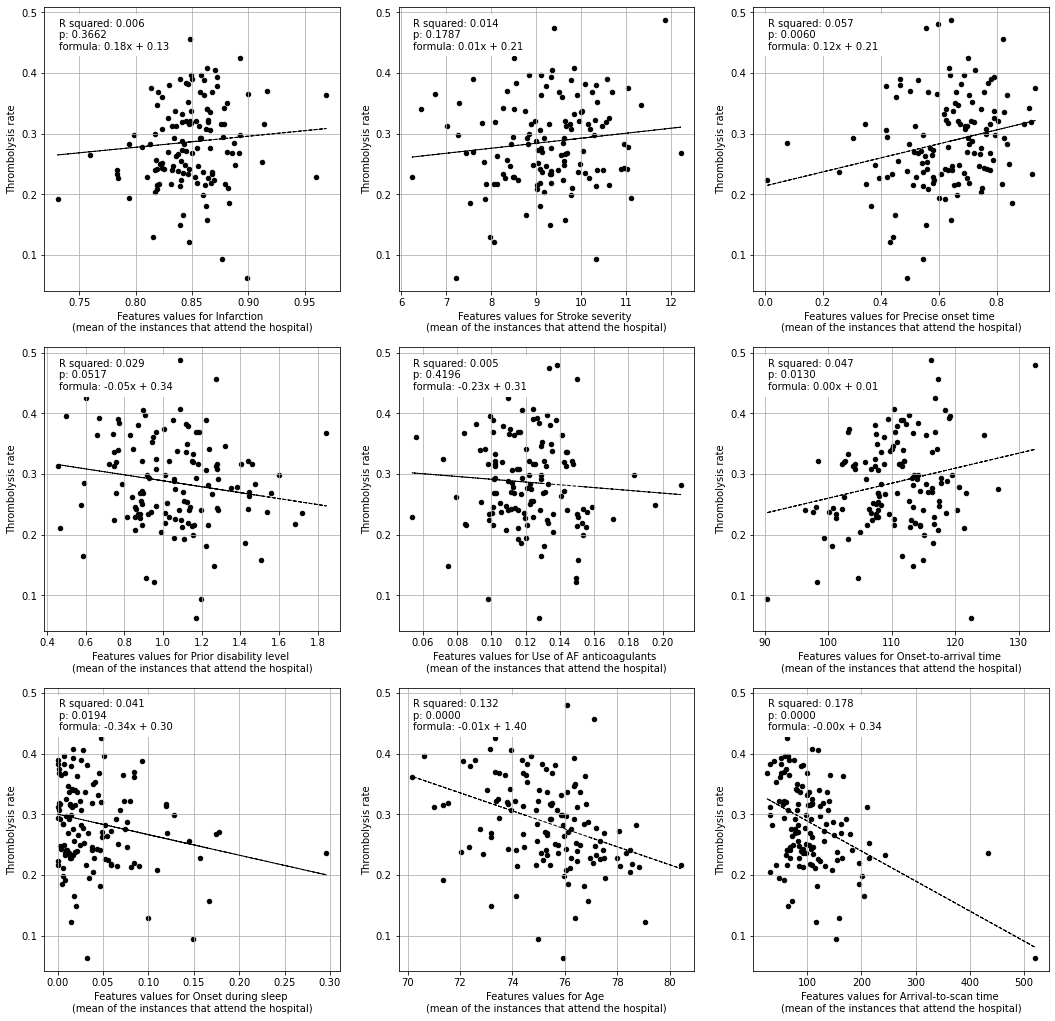

()

In [14]:
title = "Features values for"
df = df_hosp_mean_feature_values

print("Regression between hosptial IVT rate and features "
      "(mean for those instances that attend the hospital)")
print ()
plot_regressions(df, patient_features + hospital_features, title)

#### Multiple regression on just patient characteristics vs hospital thrombolysis rate

Multiple regression between hosptial IVT rate and features describing the patient (mean for those instances that attend the hospital)

                             coeff
Infarction                0.198321
Stroke severity           0.011381
Precise onset time        0.077898
Prior disability level   -0.011695
Use of AF anticoagulants  0.106239
Onset-to-arrival time     0.002768
Onset during sleep       -0.274212
Age                      -0.014752



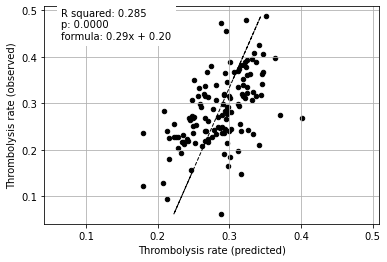

<AxesSubplot:xlabel='Thrombolysis rate (predicted)', ylabel='Thrombolysis rate (observed)'>

In [15]:
print("Multiple regression between hosptial IVT rate and features describing "
      "the patient (mean for those instances that attend the hospital)")
print()
fit_and_plot_multiple_regression(df, patient_features)

#### Multiple regression on just hospital processes vs hospital thrombolysis rate

Multiple regression between hosptial IVT rate and features describing the hospital (mean for those instances that attend the hospital)

                         coeff
Arrival-to-scan time -0.000494



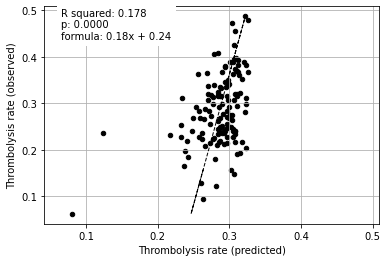

<AxesSubplot:xlabel='Thrombolysis rate (predicted)', ylabel='Thrombolysis rate (observed)'>

In [16]:
print("Multiple regression between hosptial IVT rate and features describing "
      "the hospital (mean for those instances that attend the hospital)")
print()
fit_and_plot_multiple_regression(df, hospital_features)

#### Multiple regression on all features vs hospital thrombolysis rate

Multiple regression between hosptial IVT rate and all features (mean for those instances that attend the hospital)

                             coeff
Infarction                0.415329
Stroke severity           0.005657
Precise onset time        0.041407
Prior disability level   -0.005062
Use of AF anticoagulants  0.182411
Onset-to-arrival time     0.002067
Onset during sleep       -0.310098
Age                      -0.013108
Arrival-to-scan time     -0.000437



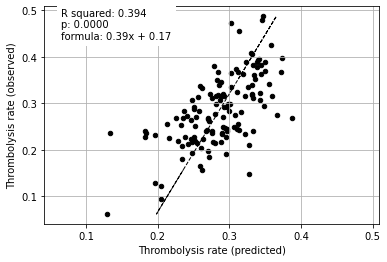

<AxesSubplot:xlabel='Thrombolysis rate (predicted)', ylabel='Thrombolysis rate (observed)'>

In [17]:
print("Multiple regression between hosptial IVT rate and all features "
      "(mean for those instances that attend the hospital)")
print()
fit_and_plot_multiple_regression(df, patient_features + hospital_features)